# **Contraste Baseado em Regras de Índices Espectrais***

O Contraste nas imagens de Sensoriamento Remoto existe em função da distribuição
dos níveis de cinza, os quais dependem da resolução radiométrica do sensor.

Entretanto estas sofrem inúmeras influências externas à sua captação, bem como influências internas ao processo de produção, que *degradam* a qualidade do contraste.

Desta forma, surge a necessidade de maximizar o contraste nestas imagens a fim de favorecer a interpretação visual.

Neste sentido, este código trabalha com a aplicação de contrastes com base em Índices Espectrais (NDVI e NDWI).

---

Organização do Código:

1. Pré-processamento: Essa é a etapa inicial do código. Todo e qualquer processamento posterior precisa ser delimitado neste momento.

* Importação das Bibliotecas Necessárias;
* Declaração de Funções;
* Leitura da imagem;
* Verificação da quantidade de Bandas;
* Separação do Conjunto de Dados em bandas;
* Coleta dos valores mínimos e máximos;

2. Geração de Histogramas: O objetivo da análise do Histograma é, justamente, subsidiar a escolha dos métodos de realce disponíveis. Não é possível fazer uma análise direcionada à classe em virtude da ausência de um dado classificado, entretanto é possível identificar a distribuição dos Números Digitais (DNs. No código foram chamados "pixel").

3. Cômputo dos Índices: Este código leva em consideração *thresholds* para definir as regiões que serão realçadas.
Nesta versão, trabalharemos somente com dois índices de vegetação (IVs): Normalized Difference Vegetation Index (NDVI) e Normalized Difference Water Index (NDWI).

4. Aplicação do Contraste: As funções de realce são previamente definidas, porém aplicadas somente após a criação dos IVs para poder verificar as regiões.

5. Apresentação dos Resultados

# **1. Pré-Processamento**

### **Bibliotecas**

In [ ]:
# Importação de bibliotecas
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
import math

In [ ]:
gdal.UseExceptions()

## **1.1. Funções**

### **1.1.1. Funções de Ajuste de Contraste**

In [ ]:
# Lista de Técnicas Disponíveis
listaDeContrastes = ['Linear', 'Quadrado', 'Raiz Quadrada', 'Logaritmo']

**Linear**

"No aumento linear de contraste, as barras que formam o histograma da imagem de saída são espaçadas igualmente, uma vez uqe a função de transferência é uma reta. O histograma de saída será idêntico, em formato, ao histograma de entrada, exceto quando ele tiver um valor médio e um espalhamento diferente" (SANTOS, 2010).

In [ ]:
def linear(pixel, min, max):
  # Como a resolução radiométrica é de 12 bits,
  # utiliza-se 4095 (0 - 4095)
  return (pixel - min) / (max - min) * max

**Quadrado**

Ao ser aplicado sobre a imagem, realça o contraste entre objetos claros na cena (SANTOS, 2010).

In [ ]:
def quadrado(pixel, max):
  return max * pixel ** 2

**Raiz Quadrada**

Realça o contraste entre objetos escuros na cena (SANTOS, 2010).

In [ ]:
def raizQuadrada(pixel, max):
  return max * pixel ** (1/2)

**Logaritmo**

Assim como a técnica de Raiz Quadrada, esta função também serve para realçar o contraste entre objetos escuros na cena (SANTOS, 2010).

In [ ]:
def logaritmo(pixel, max):
  return max * math.log10(pixel + 1)

### **1.1.2. Funções Gerais**

**Fórmula de Diferença Normalizada**

Como a *Diferença Normalizada* é uma operação que ocorre repetidamente no *script* (NDVI e NDWI se utilizam dessa expressão), é útil criar uma função que a reproduza.

Como já se supõe, essa expressão *normaliza* os dados. O intervalo dessa normalização é de -1 a 1.

In [ ]:
def normalizedDifference(band_one, band_two):
  return (band_one - band_two) / (band_one + band_two)

## **1.2. Leitura da imagem**

**Entrada do dado**

Para esta demonstração, será utilizada uma composição com quatro bandas (Blue, Green, Red e NIR), gerada na plataforma Google Earth Engine.

Critérios adotados:
* Período: 2020-01-01 a 2022-01-01
* % de nuvens: < 20
* Mediana da imagem
* Dividida por 10.000

Ordem das Bandas:
1. Blue
2. Green
3. Red
4. NIR



In [ ]:
Sentinel2_L2A = gdal.Open('/content/drive/MyDrive/INPE/Introdução à Programação com Dados Geoespaciais/Sentinel_2_4bands.tif', gdal.GA_ReadOnly)

**Coleta das quantidades de Linhas e Colunas**

As dimensões das imagens são necessárias para investigar todas as posições da cena. Desta forma, aproveita-se a ocasião da leitura dos dados para realizar essa coleta de informação.

In [ ]:
# Quantidade de Linhas
rows = Sentinel2_L2A.RasterYSize

# Quantidade de Colunas
columns = Sentinel2_L2A.RasterXSize

**Coleta da quantidade de bandas**

A quantidade de bandas é um impeditivo para a correta execução deste código.

A princípio, este trecho é meramente informativo. Entretanto, com os futuros desenvolvimentos, este trecho terá função de filtrar os dados, orientando o usuário sobre boas práticas e limitações decorrentes do número de bandas insuficientes.

In [ ]:
bandsNum = Sentinel2_L2A.RasterCount

**Coleta da quantidade de bandas**

Possibilidades disponíveis em função do número de bandas:
* 1 Banda: Realce de uma banda, sem auxílio de Índice de Vegetação;
* 2 Bandas: A depender das bandas, é possível computar um Índice de Vegetação e aplicar o contraste com base nele;
* 3 Bandas: Mesma ressalva da hipótese anterior, entretanto com melhores perspectivas. Já é possível fazer composições coloridas.

In [ ]:
if bandsNum < 2:

  print(f'O arquivo apresentado possui {bandsNum} bandas')
  print('Para utilizar este código, forneça, no mínimo, uma imagem com duas bandas')

elif bandsNum >= 2:

  print(f'O arquivo importado possui {bandsNum} bandas')
  #print('Você só poderá gerar uma combinação RGB qualquer sem contrastes baseados em Índices de Vegetação')
  #resposta = input('Deseja continuar? [S/N]\n')

O arquivo importado possui 4 bandas


**Armazenamento das bandas individuais**

Referência: https://prog-geo.github.io/imagens/gdal.html

In [ ]:
bandas = [Sentinel2_L2A.GetRasterBand(i) for i in range(1, bandsNum + 1)]

**Identificação dos Valores Máximo e Mínimo de cada banda**

Esses valores serão utilizados na Função Linear.

In [ ]:
# Mínimos e Máximos
minimum = list()
maximum = list()

for i in range(len(bandas)):
  a, b = bandas[i].ComputeRasterMinMax()
  minimum.append(a)
  maximum.append(b)

**Individualização das Bandas**

*Admite-se* que esta etapa só ocorre porque os programadores responsáveis ficaram preocupados de realizar o restante dos processamentos com listas.

In [ ]:
# As matrizes Originais são necessárias para que possamos recuperar as informações
# iniciais sem a necessidade de executar TODO o código novamente.
original_blueMatrix = bandas[0].ReadAsArray().astype(float)
original_greenMatrix = bandas[1].ReadAsArray().astype(float)
original_redMatrix = bandas[2].ReadAsArray().astype(float)
original_nirMatrix = bandas[3].ReadAsArray().astype(float)

In [ ]:
blueMatrix = original_blueMatrix.copy()
greenMatrix = original_greenMatrix.copy()
redMatrix = original_redMatrix.copy()
nirMatrix = original_nirMatrix.copy()

# **2. Histograma**

**Interpretação do Histograma**

A aplicação de realces de contraste pretende melhorar a distribuição dos valores dos pixels presentes na cena. Assim, é útil conhecer essa distribuição ANTES de optarmos por uma ou outra técnica de realce.

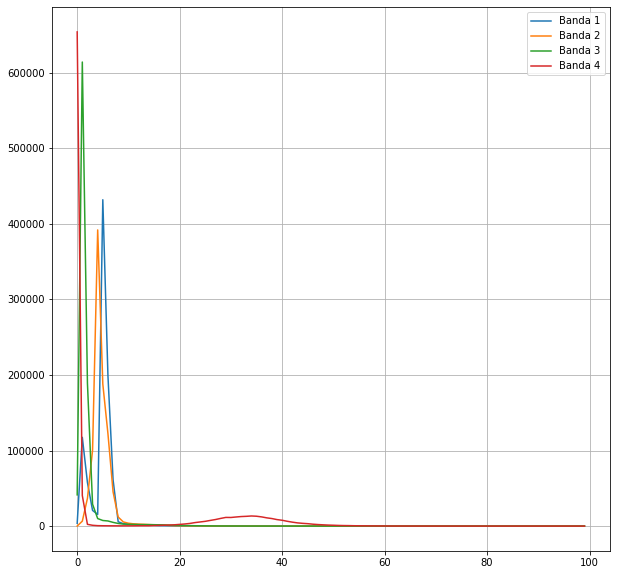

In [ ]:
plt.figure(figsize = (10, 10))
for i in range(len(bandas)):
  plt.plot(bandas[i].GetHistogram(min = minimum[i], max = maximum[i], buckets = 100), label = 'Banda ' + str(i + 1))
plt.grid()
plt.legend()

# **3. Índices de Vegetação**

Neste momento, os Índices de Vegetação utilizados são dois: 
* *Normalized Difference Vegetation Index* (Índice de Vegetação por Diferença Normalizada); e
* *Normalized Difference Water Index* (Índice de Água por Diferença Normalizada)

Referência: https://www.indexdatabase.de/

In [ ]:
NDVI = normalizedDifference(nirMatrix, redMatrix)
NDWI = normalizedDifference(greenMatrix, nirMatrix)

**Visualização Espacial do Índice de Vegetação**

Com o objetivo de auxiliar na tomada de decisão, exibe-se os plots dos IVs, a fim de facilitar a leitura do intérprete.

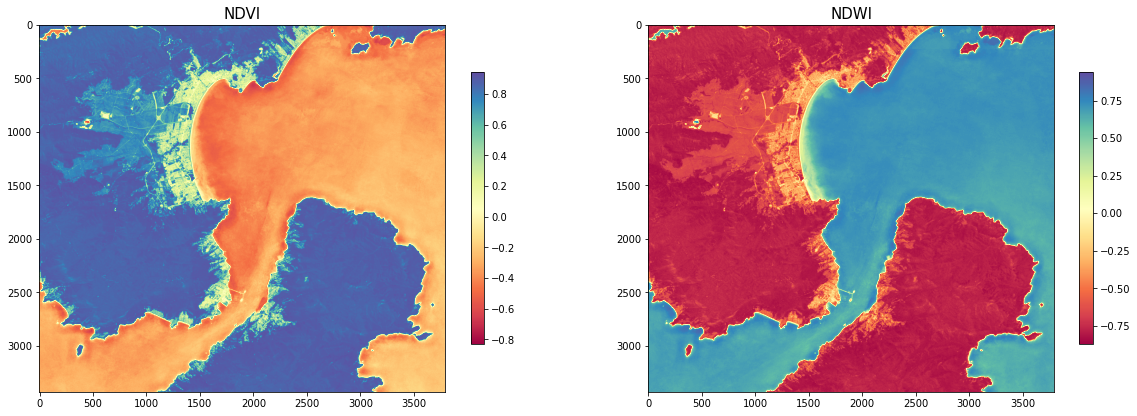

In [ ]:
plt.figure(figsize = (20, 10))

plt.subplot(1, 2, 1)
plt.title('NDVI', size = 15)
plt.imshow(NDVI, cmap = 'Spectral', vmin = np.amin(NDVI), vmax = np.amax(NDVI))
plt.colorbar(shrink = 0.5)

plt.subplot(1, 2, 2)
plt.title("NDWI", size = 15)
plt.imshow(NDWI, cmap='Spectral', vmin= np.amin(NDWI), vmax= np.amax(NDWI))
plt.colorbar(shrink = 0.5);

NDWI < ndwiThreshold
* NDVI >= ndviThreshold == Vegetação

NDWI >= ndwiThreshold
* NDVI < ndviThreshold == ÁGUA

NDVI < ndviThreshold E NDWI < ndwiThreshold == URBANO

In [ ]:
# Binarização dos dados para testar os limiares (thresholds)
binaryNDVI = np.zeros_like(NDVI)
binaryNDVI = np.where(NDVI >= 0.4, 1, 0)
binaryNDWI = np.zeros_like(NDWI)
binaryNDWI = np.where(NDWI >= 0.4, 1, 0)

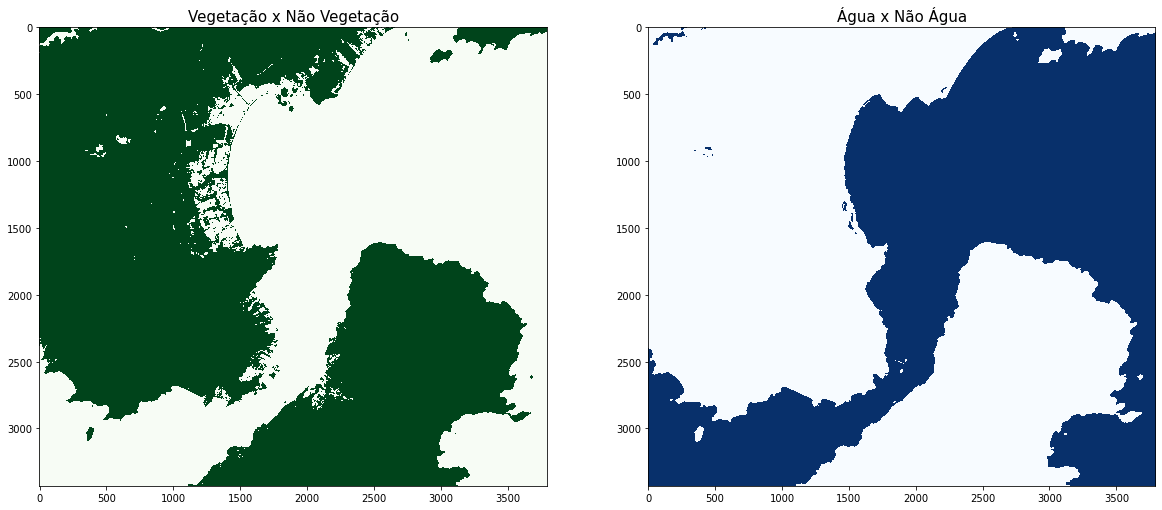

In [ ]:
plt.figure(figsize = (20, 10))

plt.subplot(1, 2, 1)
plt.title('Vegetação x Não Vegetação', size = 15)
colormap_2classes = plt.get_cmap('Greens', 2)
plt.imshow(binaryNDVI, cmap=colormap_2classes)

plt.subplot(1, 2, 2)
plt.title('Água x Não Água', size = 15)
colormap_2classes = plt.get_cmap('Blues', 2)
plt.imshow(binaryNDWI, cmap=colormap_2classes);

# **4. Aplicação do Contraste**

## **4.1. Interação com o usuário**

Primeiro esforço em direção a um *script* interativo.

In [ ]:
print('{:^60}\n'.format('TÉCNICAS DE CONTRASTE') + '=' * 60)
for i, j in enumerate(listaDeContrastes):
  print('{:.<30}{:.>30}'.format(j, (i + 1)))
print('=' * 60)
print('Opções disponíveis. Digite o código da técnica de interesse')

                   TÉCNICAS DE CONTRASTE                    
Linear.....................................................1
Quadrado...................................................2
Raiz Quadrada..............................................3
Logaritmo..................................................4
Opções disponíveis. Digite o código da técnica de interesse


In [ ]:
flag = True
while flag:
  vegContrast = input('Qual contraste deseja aplicar à Vegetação?\n')
  waterContrast = input('Qual contraste deseja aplicar à Água?\n')
  urbanContrast = input('Qual contraste deseja aplicar ao ambiente Urbano?\n')
  if 1 <= int(vegContrast) <= 4 and 1 <= int(waterContrast) <= 4 and 1 <= int(urbanContrast) <= 4:
    flag = False
  else:
    print('Por favor, digite valores correspondentes ao intervalo indicado')
  
vegContrast = int(vegContrast)
waterContrast = int(waterContrast)
urbanContrast = int(urbanContrast)

Qual contraste deseja aplicar à Vegetação?
1
Qual contraste deseja aplicar à Água?
2
Qual contraste deseja aplicar ao ambiente Urbano?
3


## **4.2. Limiares**

A interpretação desse trecho é simples: a partir de qual valor (threshold) o código deve interpretar como Vegetação/Água.

Para maior segurança na seleção do valor, observar os plots de IVs na seção 3.

In [ ]:
ndviThreshold = float(input('Qual o limite de vegetação no NDVI? \n'))
ndwiThreshold = float(input('Qual o limite de água no NDWI? \n'))

Qual o limite de vegetação no NDVI? 
0.4
Qual o limite de água no NDWI? 
0.6


## **4.3. Computação dos Realces**

A duração dessa etapa depende do tamanho da cena inserida e do tipo de contraste selecionado.

In [ ]:
blueMatrix = original_blueMatrix.copy()
greenMatrix = original_greenMatrix.copy()
redMatrix = original_redMatrix.copy()
nirMatrix = original_nirMatrix.copy()

for i in range(rows):
  for j in range(columns):
    # VEGETAÇÃO
    if NDVI[i][j] >= ndviThreshold and NDWI[i][j] < ndwiThreshold:

      if vegContrast == 1:

        blueMatrix[i][j]  = linear(blueMatrix[i][j], minimum[0], maximum[0])
        greenMatrix[i][j] = linear(greenMatrix[i][j], minimum[1], maximum[1])
        redMatrix[i][j]   = linear(redMatrix[i][j], minimum[2], maximum[2])
        nirMatrix[i][j]   = linear(nirMatrix[i][j], minimum[3], maximum[3])

      elif vegContrast == 2:

        blueMatrix[i][j]  = quadrado(blueMatrix[i][j], maximum[0])
        greenMatrix[i][j] = quadrado(greenMatrix[i][j], maximum[1])
        redMatrix[i][j]   = quadrado(redMatrix[i][j], maximum[2])
        nirMatrix[i][j]   = quadrado(nirMatrix[i][j], maximum[3])

      elif vegContrast == 3:

        blueMatrix[i][j]  = raizQuadrada(blueMatrix[i][j], maximum[0])
        greenMatrix[i][j] = raizQuadrada(greenMatrix[i][j], maximum[1])
        redMatrix[i][j]   = raizQuadrada(redMatrix[i][j], maximum[2])
        nirMatrix[i][j]   = raizQuadrada(nirMatrix[i][j], maximum[3])

      elif vegContrast == 4:

        blueMatrix[i][j]  = logaritmo(blueMatrix[i][j], maximum[0])
        greenMatrix[i][j] = logaritmo(greenMatrix[i][j], maximum[1])
        redMatrix[i][j]   = logaritmo(redMatrix[i][j], maximum[2])
        nirMatrix[i][j]   = logaritmo(nirMatrix[i][j], maximum[3])
    
    # ÁGUA
    elif NDVI[i][j] < ndviThreshold and NDWI[i][j] >= ndwiThreshold:
      
      if waterContrast == 1:
        
        blueMatrix[i][j]  = linear(blueMatrix[i][j], minimum[0], maximum[0])
        greenMatrix[i][j] = linear(greenMatrix[i][j], minimum[1], maximum[1])
        redMatrix[i][j]   = linear(redMatrix[i][j], minimum[2], maximum[2])
        nirMatrix[i][j]   = linear(nirMatrix[i][j], minimum[3], maximum[3])

      elif waterContrast == 2:
        
        blueMatrix[i][j]  = quadrado(blueMatrix[i][j], maximum[0])
        greenMatrix[i][j] = quadrado(greenMatrix[i][j], maximum[1])
        redMatrix[i][j]   = quadrado(redMatrix[i][j], maximum[2])
        nirMatrix[i][j]   = quadrado(nirMatrix[i][j], maximum[3])

      elif waterContrast == 3:

        blueMatrix[i][j]  = raizQuadrada(blueMatrix[i][j], maximum[0])
        greenMatrix[i][j] = raizQuadrada(greenMatrix[i][j], maximum[1])
        redMatrix[i][j]   = raizQuadrada(redMatrix[i][j], maximum[2])
        nirMatrix[i][j]   = raizQuadrada(nirMatrix[i][j], maximum[3])

      elif waterContrast == 4:

        blueMatrix[i][j]  = logaritmo(blueMatrix[i][j], maximum[0])
        greenMatrix[i][j] = logaritmo(greenMatrix[i][j], maximum[1])
        redMatrix[i][j]   = logaritmo(redMatrix[i][j], maximum[2])
        nirMatrix[i][j]   = logaritmo(nirMatrix[i][j], maximum[3])
    
    # Ambiente Urbano
    else:

      if urbanContrast == 1:

        blueMatrix[i][j]  = linear(blueMatrix[i][j], minimum[0], maximum[0])
        greenMatrix[i][j] = linear(greenMatrix[i][j], minimum[1], maximum[1])
        redMatrix[i][j]   = linear(redMatrix[i][j], minimum[2], maximum[2])
        nirMatrix[i][j]   = linear(nirMatrix[i][j], minimum[3], maximum[3])

      elif urbanContrast == 2:

        blueMatrix[i][j]  = quadrado(blueMatrix[i][j], maximum[0])
        greenMatrix[i][j] = quadrado(greenMatrix[i][j], maximum[1])
        redMatrix[i][j]   = quadrado(redMatrix[i][j], maximum[2])
        nirMatrix[i][j]   = quadrado(nirMatrix[i][j], maximum[3])

      elif urbanContrast == 3:

        blueMatrix[i][j]  = raizQuadrada(blueMatrix[i][j], maximum[0])
        greenMatrix[i][j] = raizQuadrada(greenMatrix[i][j], maximum[1])
        redMatrix[i][j]   = raizQuadrada(redMatrix[i][j], maximum[2])
        nirMatrix[i][j]   = raizQuadrada(nirMatrix[i][j], maximum[3])

      elif urbanContrast == 4:

        blueMatrix[i][j]  = logaritmo(blueMatrix[i][j], maximum[0])
        greenMatrix[i][j] = logaritmo(greenMatrix[i][j], maximum[1])
        redMatrix[i][j]   = logaritmo(redMatrix[i][j], maximum[2])
        nirMatrix[i][j]   = logaritmo(nirMatrix[i][j], maximum[3])

# **5. Visualização dos Resultados**

## **5.1. Visualização dos Resultados Individuais**

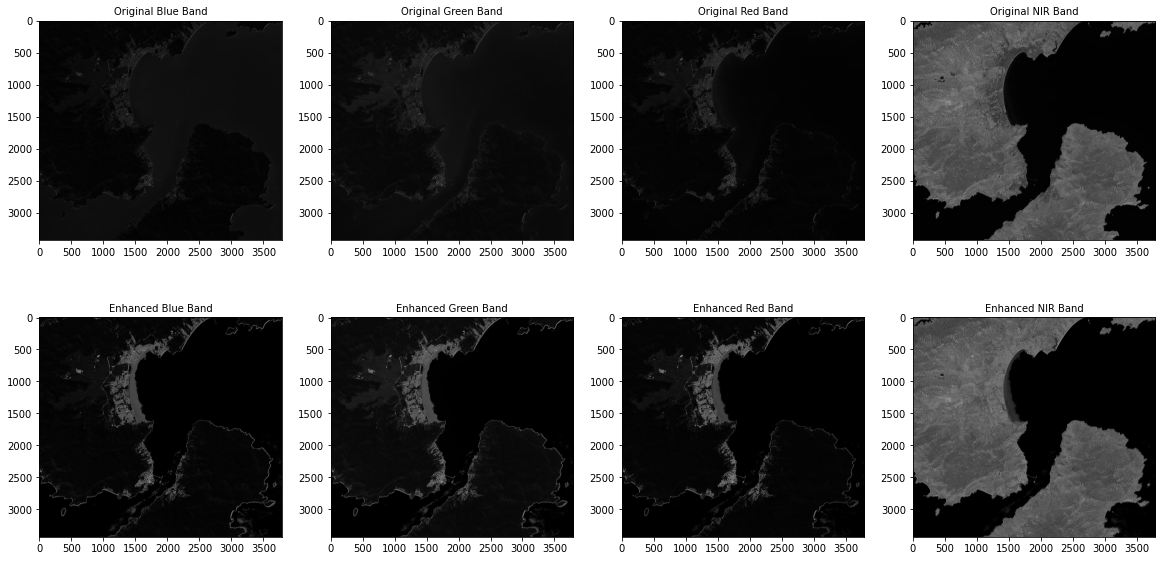

In [ ]:
plt.figure(figsize = (20, 10))

plt.subplot(2, 4, 1)
plt.title("Original Blue Band", size = 10)
plt.imshow(original_blueMatrix, cmap='gray', vmin = np.amin(original_blueMatrix), vmax = np.amax(original_blueMatrix))

plt.subplot(2, 4, 2)
plt.title("Original Green Band", size = 10)
plt.imshow(original_greenMatrix, cmap='gray', vmin = np.amin(original_greenMatrix), vmax = np.amax(original_greenMatrix))

plt.subplot(2, 4, 3)
plt.title("Original Red Band", size = 10)
plt.imshow(original_redMatrix, cmap='gray', vmin = np.amin(original_redMatrix), vmax = np.amax(original_redMatrix))

plt.subplot(2, 4, 4)
plt.title("Original NIR Band", size = 10)
plt.imshow(original_nirMatrix, cmap='gray', vmin = np.amin(original_nirMatrix), vmax = np.amax(original_nirMatrix))

plt.subplot(2, 4, 5)
plt.title("Enhanced Blue Band", size = 10)
plt.imshow(blueMatrix, cmap='gray', vmin = np.amin(blueMatrix), vmax = np.amax(blueMatrix))

plt.subplot(2, 4, 6)
plt.title("Enhanced Green Band", size = 10)
plt.imshow(greenMatrix, cmap='gray', vmin = np.amin(greenMatrix), vmax = np.amax(greenMatrix))

plt.subplot(2, 4, 7)
plt.title("Enhanced Red Band", size = 10)
plt.imshow(redMatrix, cmap='gray', vmin = np.amin(redMatrix), vmax = np.amax(redMatrix))

plt.subplot(2, 4, 8)
plt.title("Enhanced NIR Band", size = 10)
plt.imshow(nirMatrix, cmap='gray', vmin = np.amin(nirMatrix), vmax = np.amax(nirMatrix));


## **5.2. Composição Colorida Cor Verdadeira**

In [ ]:
trueColour = np.zeros((rows, columns, 3))
enhancedTrueColour = trueColour.copy()

In [ ]:
trueColour[:, :, 2] = original_blueMatrix
trueColour[:, :, 1] = original_greenMatrix
trueColour[:, :, 0] = original_redMatrix

In [ ]:
enhancedTrueColour[:, :, 2] = blueMatrix
enhancedTrueColour[:, :, 1] = nirMatrix
enhancedTrueColour[:, :, 0] = redMatrix

In [ ]:
print(np.amin(trueColour), np.amax(trueColour))

0.004650000017136335 0.7897999882698059


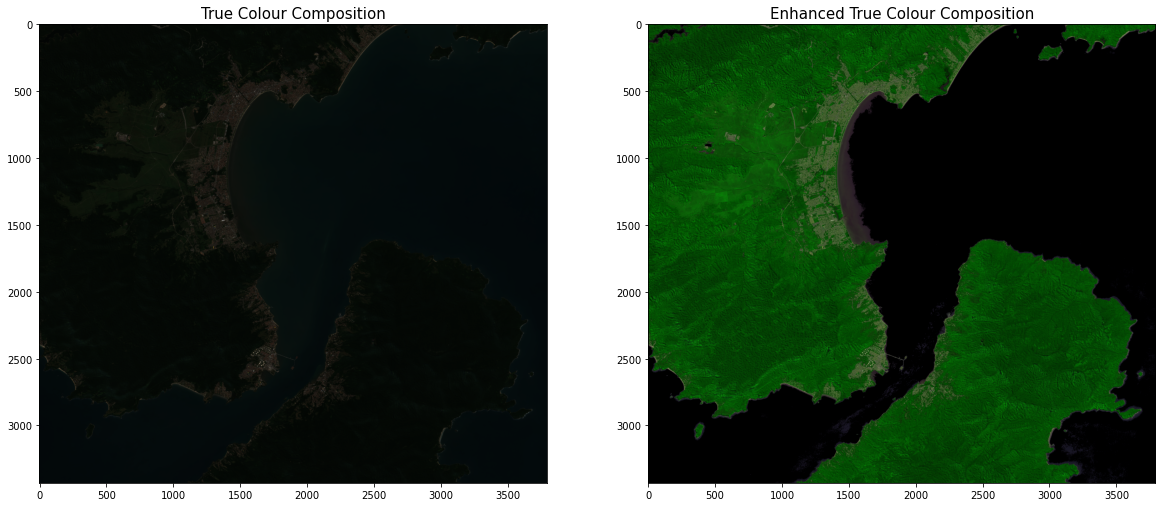

In [ ]:
plt.figure(figsize = (20, 10))

plt.subplot(1, 2, 1)
plt.title('True Colour Composition', size = 15)
plt.imshow(trueColour, vmin = np.amin(trueColour), vmax = np.amax(trueColour))

plt.subplot(1, 2, 2)
plt.title('Enhanced True Colour Composition', size = 15)
plt.imshow(enhancedTrueColour, vmin = np.amin(enhancedTrueColour), vmax = np.amax(enhancedTrueColour));

## **5.3. Composição Colorida Falsa Cor**

In [ ]:
falseColour = np.zeros((rows, columns, 3))
enhancedFalseColour = falseColour.copy()

In [ ]:
falseColour[:, :, 2] = original_greenMatrix
falseColour[:, :, 1] = original_redMatrix
falseColour[:, :, 0] = original_nirMatrix

In [ ]:
enhancedFalseColour[:, :, 2] = greenMatrix
enhancedFalseColour[:, :, 1] = redMatrix
enhancedFalseColour[:, :, 0] = nirMatrix

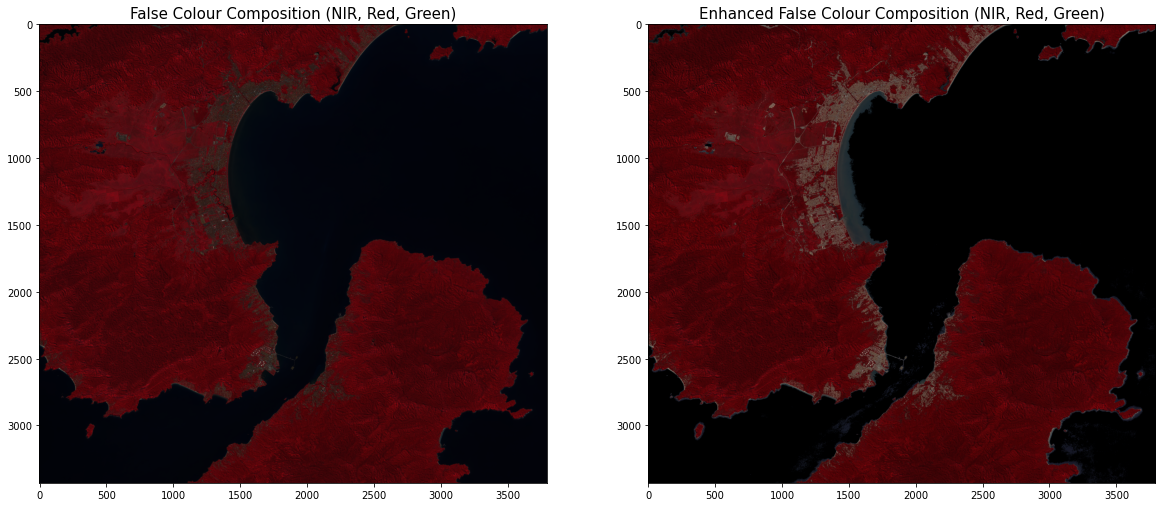

In [ ]:
plt.figure(figsize = (20, 10))

plt.subplot(1, 2, 1)
plt.title('False Colour Composition (NIR, Red, Green)', size = 15)
plt.imshow(falseColour, vmin = np.amin(falseColour), vmax = np.amax(falseColour))

plt.subplot(1, 2, 2)
plt.title('Enhanced False Colour Composition (NIR, Red, Green)', size = 15)
plt.imshow(enhancedFalseColour, vmin = np.amin(enhancedFalseColour), vmax = np.amin(enhancedFalseColour));